In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from qulacs import QuantumState, Observable, ParametricQuantumCircuit
from qulacs.gate import CZ
from scipy.sparse.linalg import eigs
import numpy as np


class DigitalPerceptron:

    def __init__(self, n_qubits, depth, parameters = None, seed = None, loss_hamiltonian = None, loss_hamiltonian_spectrum = None):

        self.n_qubits = n_qubits
        self.depth = depth
        self.loss_hamiltonian = loss_hamiltonian
        self.loss_hamiltonian_spectrum = loss_hamiltonian_spectrum

        gates_per_layer = n_qubits
        self.parameters_dim = gates_per_layer*4*depth

        if parameters is not None:
            self.parameters = parameters
        else:
            np.random.seed(seed)
            self.parameters = np.random.random(self.parameters_dim)*1e-1
        

        self.ansatz_circuit()


    def ansatz_circuit(self):
        """ansatz_circuit
        Prepares ansatz circuit.

        Args:
            self (:class:`DigitalPerceptron`):

        Returns:
            None
        """

        circuit = ParametricQuantumCircuit(self.n_qubits)

        gate_offset = 1 * self.n_qubits # number of parameters per operator times number of operators
        
        for d in range(self.depth):

            depth_offset = d*gate_offset*4

            for i in range(self.n_qubits):
                theta = self.parameters[i + gate_offset*0 + depth_offset]
                circuit.add_parametric_RX_gate(i, theta)

            for i in range(self.n_qubits):
                theta = self.parameters[i + gate_offset*1 + depth_offset]
                circuit.add_parametric_RZ_gate(i, theta)


            for i in range(self.n_qubits-1):
                gate = CZ(i, self.n_qubits-1)

            for i in range(self.n_qubits):
                theta = self.parameters[i + gate_offset*2 + depth_offset]
                circuit.add_parametric_RX_gate(i, theta)

            for i in range(self.n_qubits):
                theta = self.parameters[i+ gate_offset*3 + depth_offset]
                circuit.add_parametric_RZ_gate(i, theta)

            self.ansatz_circuit = circuit

    
    def ising_model_H(self, transverse_field_coefficient):
        """ising_model_H
        Builds ID Ising model Hamiltonian observable as loss Hamiltonian

        Args:
            self (:class:`DigitalPerceptron`):
                
            transverse_field_coefficient (:class:`float`):
                h parameter of Hamiltonian

        Returns:
            None

        """

        ising_hamiltonian = Observable(self.n_qubits)

        # Building the Transverse field Ising Hamiltonian
        for i in range(self.n_qubits-1): ising_hamiltonian.add_operator(1.0 ,f"Z {i} Z {i+1}")
        for i in range(self.n_qubits): ising_hamiltonian.add_operator(transverse_field_coefficient, f"X {i}")

        loss_hamiltonian_sepctrum = np.real(eigs(ising_hamiltonian.get_matrix())[0])

        self.loss_hamiltonian = ising_hamiltonian
        self.loss_hamiltonian_spectrum = np.sort(loss_hamiltonian_sepctrum)


    def loss(self):

        state = QuantumState(self.n_qubits)
        self.ansatz_circuit.update_quantum_state(state)
        return self.loss_hamiltonian.get_expectation_value(state)



    

In [3]:
# Defining the VQE parameters

n_qubits = 8
depth = n_qubits
h = 0.1

perceptron = DigitalPerceptron(n_qubits, depth)
perceptron.ising_model_H(h)
print(perceptron.loss_hamiltonian)

print(perceptron.loss())

1 Z 0 Z 1 + 1 Z 1 Z 2 + 1 Z 2 Z 3 + 1 Z 3 Z 4 + 1 Z 4 Z 5 + 1 Z 5 Z 6 + 1 Z 6 Z 7 + 0.1 X 0 + 0.1 X 1 + 0.1 X 2 + 0.1 X 3 + 0.1 X 4 + 0.1 X 5 + 0.1 X 6 + 0.1 X 7
3.489695642909755


In [26]:
# Defining Ising Hamiltonian
from qulacs import Observable
from scipy.sparse.linalg import eigs

def ising_model_H(n_qubits, h_parameter):
    """ising_model_H
    Returns Ising model Hamiltonian observable

    Args:
        n_qubits (:class:`int`):
            the number of qubits
        h_parameter (:class:`float`)
            h parameter of Hamiltonian

    Returns:
        :class:`qulacs.Observable`

    """

    ising_hamiltonian = Observable(n_qubits)

    # Building the Transverse field Ising Hamiltonian
    for i in range(n_qubits-1): ising_hamiltonian.add_operator(1.0 ,f"Z {i} Z {i+1}")
    for i in range(n_qubits): ising_hamiltonian.add_operator(h_parameter, f"X {i}")

    energies = np.real(eigs(ising_hamiltonian.get_matrix())[0])

    return ising_hamiltonian, energies

ising_hamiltonian, energies = ising_model_H(n_qubits, h)


In [27]:
from qulacs import ParametricQuantumCircuit
from qulacs.gate import CZ

def ansatz_circuit(n_qubits, depth, param_list):
    """ansatz_circuit
    Returns ansatz circuit.

    Args:
        n_qubit (:class:`int`):
            the number of qubits.
        depth (:class:`int`):
            depth of the circuit (the number of layers).
        param_list (:class:`numpy.ndarray`):
            rotation angles.
    Returns:
        :class:`qulacs.ParametricQuantumCircuit`
    """

    circuit = ParametricQuantumCircuit(n_qubits)

    gate_offset = 1 * n_qubits # number of parameters per operator times number of operators
    
    for d in range(depth):

        depth_offset = d*gate_offset*4
        # print(depth_offset)

        # print("new layer with depth offset ", depth_offset)

        for i in range(n_qubits):
            theta = param_list[i + gate_offset*0 + depth_offset]
            # print("RX layer ", param_list[i + gate_offset*0 + depth_offset])
            # gate = RX(i, param_list[i + gate_offset*0 + depth_offset])
            circuit.add_parametric_RX_gate(i, theta)

        for i in range(n_qubits):
            theta = param_list[i + gate_offset*1 + depth_offset]
            # print("RZ layer ", param_list[i + gate_offset*1 + depth_offset])
            # gate = RZ(i, param_list[i + gate_offset*1 + depth_offset])
            circuit.add_parametric_RZ_gate(i, theta)


        for i in range(n_qubits-1):
            gate = CZ(i, n_qubits-1)

        for i in range(n_qubits):
            theta = param_list[i + gate_offset*2 + depth_offset]
            # print("RX layer ", param_list[i + gate_offset*2 + depth_offset])
            # gate = RX(i, param_list[i + gate_offset*2 + depth_offset])
            circuit.add_parametric_RX_gate(i, theta)

        for i in range(n_qubits):
            theta = param_list[i+ gate_offset*3 + depth_offset]
            # print("RZ layer ", param_list[i + gate_offset*3 + depth_offset])
            # gate = RZ(i, param_list[i+ gate_offset*3 + depth_offset])
            circuit.add_parametric_RZ_gate(i, theta)


    return circuit


In [8]:
from qulacs import QuantumState

def loss_function(param_list, n_qubits, depth, transverse_field_coefficient):
    
    loss_perceptron = DigitalPerceptron(n_qubits, depth, parameters=param_list)
    loss_perceptron.ising_model_H(transverse_field_coefficient)
    # state = QuantumState(n_qubits)
    # circuit = ansatz_circuit(n_qubits, depth, param_list)
    # circuit.update_quantum_state(state)
    # return ising_hamiltonian.get_expectation_value(state)

    return loss_perceptron.loss()


In [9]:
%%time

param_list = perceptron.parameters


loss_function(param_list, n_qubits, depth, h)

CPU times: user 1 s, sys: 29.1 ms, total: 1.03 s
Wall time: 208 ms


3.489695642909755

In [147]:
def gradient_descent_optimizer(initial_parameters, loss_hamiltonian, n_iters, learning_rate):

    cost_history = []
    param_history = []

    param_list = initial_parameters

    for i in range(n_iters):

        circuit = ansatz_circuit(n_qubits, depth, param_list)

        gradient = np.asarray(circuit.backprop(loss_hamiltonian))

        param_list = param_list - gradient * learning_rate
        param_history.append(param_list)
        cost_history.append(loss_function(param_list))

    return param_list, cost_history, param_history

In [30]:
cost_history

[1.7500146219707426,
 1.0607584153108185,
 -1.6393849533091474,
 -1.8427137668045714,
 -2.0886160206044586,
 -2.2259464288400417,
 -2.181087594845499,
 -3.5625678350209284,
 -4.607105012056706,
 -4.6372638499070895,
 -3.965265746794951,
 -2.8224970544209596,
 -3.4621128821481104,
 -3.331288027310423,
 -4.058466427519372,
 -4.488787034886779,
 -4.819243559262942,
 -4.94582242207083,
 -4.978173780607851,
 -4.911266153634285,
 -4.533784107792769,
 -3.4141013674501526,
 -2.742404919498116,
 -3.3910070086298028,
 -2.6256024337278494,
 -2.677335952378901,
 -0.9163497482714148,
 -1.4205222141801588,
 -1.3261642471968074,
 -1.9696751533001715,
 -2.6575194465354812,
 -3.2629229355066407,
 -3.6559092473605754,
 -3.5949985074653132,
 -4.182489849097152,
 -4.235989770002057,
 -4.559388731834761,
 -4.667808763111996,
 -4.772069748105887,
 -4.800586974387373,
 -4.786972870362854,
 -4.757197656042296,
 -4.696995202791978,
 -4.67694855483763,
 -4.636964572167729,
 -4.67218475454846,
 -4.67117647618696

Gradient descent optimization (200 iterations with learning rate of 0.01) :
Found ground state energy: -7.024309218259795
Real ground state energy: -7.025018814833035
Hamiltonian spectrum: [-7.02501881 -7.0250188  -5.20772968  5.20772968  7.0250188   7.02501881]


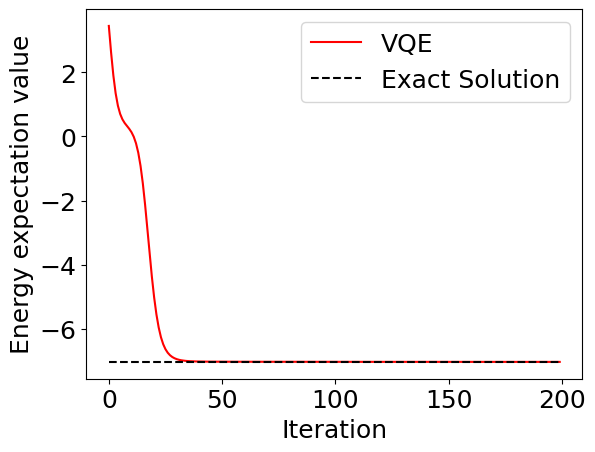

In [148]:
gs_energy = np.amin(energies)

depth = n_qubits
gates_per_layer = n_qubits
param_dim = gates_per_layer*4*depth
initial_parameters = np.random.random(param_dim)*1e-1
n_iters = 200
lr = 0.01

print(f"Gradient descent optimization ({n_iters} iterations with learning rate of {lr}) :")

final_parameters, cost_history, param_history = gradient_descent_optimizer(initial_parameters, ising_hamiltonian, n_iters, lr)

print(f"Found ground state energy: {loss_function(final_parameters)}")
print(f"Real ground state energy: {gs_energy}")

print(f"Hamiltonian spectrum: {np.sort(energies)}")


plt.rcParams["font.size"] = 18
plt.plot(cost_history, color="red", label="VQE")
plt.plot(range(len(cost_history)), [gs_energy]*len(cost_history), linestyle="dashed", color="black", label="Exact Solution")
plt.xlabel("Iteration")
plt.ylabel("Energy expectation value")
plt.legend()
plt.show()